# 📊 Predicción de fuente de infección - Machine Learning
### Samuel Pérez Hurtado

Se importan todas las librerías que se van a usar en el trabajo.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

# 1 - Explicación del Dataset
Los datos fueron extraídos de OpenData Medellín, se trata de los casos positivos de la viruela símica en el municipio de Medellín.
<br>
Se desea crear una red neuronal multiclase que permita clasificar la fuente de la infección dados atributos como la semana de la infección, el año, el género y la edad de la persona.
<br>
Las variables de entrada seleccionadas (porque están relacionadas con la variable objetivo) son las siguientes:

**Semana:** Se refiere a la semana del año en que se reportó el inicio de los síntomas <br>
**Año:** Se refiere al año en que se reportó el inicio de los síntomas <br>
**Sexo:** Se refiere al género (masculino o femenino) de la persona infectada <br>
**Edad:** Se refiere a la edad de la persona en el momento de la infección <br>
**Vínculo epidemiológico:** Se refiere al vínculo epidemiológico de la persona (1 si tuvo contacto o fue caso importado y 0 si se desconoce) <br>
**Viajó:** Se refiere a si la persona viajó en los últimos 14 días fuera del país (0 = NO, 1 = SI)

La variable objetivo es:
<br>
**Fuente de la infección:** Se refiere a la proveniencia de la enfermedad (FUENTE DESCONOCIDA, IMPORTADO, RELACIONADO CON LA FUENTE DESCONOCIDA, RELACIONADO CON LA IMPORTACIÓN)

In [2]:
df = pd.read_excel('Casos positivos de viruela símica Medellín.xlsx')
df

,Semana,Año,Sexo,Edad,Vínculo epidemiológico,Viajó,Fuente de la infección
0,37,2022,M,37,1,0,RELACIONADO CON FUENTE DESCONOCIDA
1,33,2022,M,26,2,0,FUENTE DESCONOCIDA
2,37,2022,M,37,2,0,FUENTE DESCONOCIDA
3,34,2022,M,31,2,0,FUENTE DESCONOCIDA
4,35,2022,M,33,2,0,FUENTE DESCONOCIDA
...,...,...,...,...,...,...,...
999,41,2022,M,26,2,0,FUENTE DESCONOCIDA
1000,43,2022,M,28,2,0,FUENTE DESCONOCIDA
1001,43,2022,M,33,2,0,FUENTE DESCONOCIDA
1002,42,2022,M,39,2,0,FUENTE DESCONOCIDA


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1004 entries, 0 to 1003
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Semana                  1004 non-null   int64 
 1   Año                     1004 non-null   int64 
 2   Sexo                    1004 non-null   object
 3   Edad                    1004 non-null   int64 
 4   Vínculo epidemiológico  1004 non-null   int64 
 5   Viajó                   1004 non-null   int64 
 6   Fuente de la infección  1004 non-null   object
dtypes: int64(5), object(2)
memory usage: 55.0+ KB


<Axes: ylabel='count'>

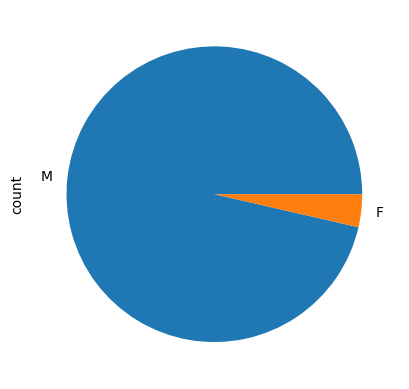

In [4]:
df['Sexo'].value_counts().plot(kind='pie')

<Axes: >

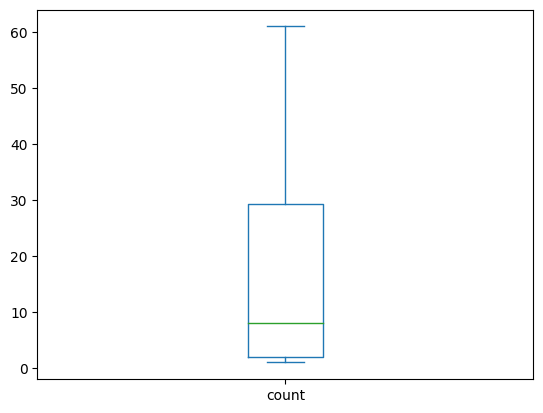

In [5]:
df['Edad'].value_counts().plot(kind='box')

# 2 - Normalización
Se pide que los datos tengan media 0 y desviación estándar 1. Se decide recurrir a una función de Sklearn llamada StandardScaler
<br>
El proceso de normalización realizado por StandardScaler implica restar la media de los datos y luego dividir por la desviación estándar. Esto transforma los datos de manera que tengan una media de 0 y una desviación estándar de 1, lo que facilita el análisis y mejora el rendimiento de muchos algoritmos de aprendizaje automático.

In [6]:
# Convertir columna 'Sexo' en variables ficticias (dummies)
columna_categorica = 'Sexo'
variables_dummies = pd.get_dummies(df[columna_categorica], prefix=columna_categorica, drop_first=True)

# Reemplazar False y True por 0 y 1 en las variables ficticias
variables_dummies = variables_dummies.astype(int)

# Concatenar variables ficticias al DataFrame original
df = pd.concat([df, variables_dummies], axis=1)

# Eliminar columna 'Sexo' original
df.drop(columna_categorica, axis=1, inplace=True)

#Conservar el nombre de la variable original
df = df.rename(columns={'Sexo_M': columna_categorica})

# Columnas numéricas para aplicar StandardScaler
columnas_numericas = ['Semana', 'Año', 'Edad', 'Vínculo epidemiológico', 'Viajó', 'Sexo']

# Crear objeto StandardScaler
scaler = StandardScaler()

# Aplicar StandardScaler a las columnas numéricas en df
df[columnas_numericas] = scaler.fit_transform(df[columnas_numericas])

df

,Semana,Año,Edad,Vínculo epidemiológico,Viajó,Fuente de la infección,Sexo
0,-0.105598,-0.054745,0.499811,-4.153859,-0.178494,RELACIONADO CON FUENTE DESCONOCIDA,0.192847
1,-1.129950,-0.054745,-0.787481,0.240740,-0.178494,FUENTE DESCONOCIDA,0.192847
2,-0.105598,-0.054745,0.499811,0.240740,-0.178494,FUENTE DESCONOCIDA,0.192847
3,-0.873862,-0.054745,-0.202349,0.240740,-0.178494,FUENTE DESCONOCIDA,0.192847
4,-0.617774,-0.054745,0.031704,0.240740,-0.178494,FUENTE DESCONOCIDA,0.192847
...,...,...,...,...,...,...,...
999,0.918754,-0.054745,-0.787481,0.240740,-0.178494,FUENTE DESCONOCIDA,0.192847
1000,1.430930,-0.054745,-0.553428,0.240740,-0.178494,FUENTE DESCONOCIDA,0.192847
1001,1.430930,-0.054745,0.031704,0.240740,-0.178494,FUENTE DESCONOCIDA,0.192847
1002,1.174842,-0.054745,0.733864,0.240740,-0.178494,FUENTE DESCONOCIDA,0.192847


# 3 - Balanceo


<Axes: xlabel='Fuente de la infección'>

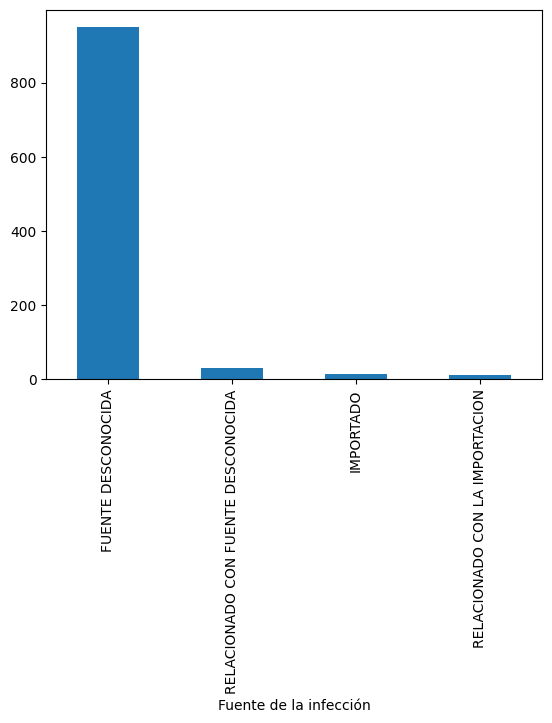

In [7]:
df['Fuente de la infección'].value_counts().plot(kind='bar')

Se puede evidenciar un desbalanceo en los datos de la variable objetivo, esto implica que el modelo sea muy bueno prediciendo FUENTE DESCONOCIDA pero no las otras 3 opciones.
<br>
Por lo tanto, se decide usar una técnica llamada SMOTE (Synthetic Minority Over-sampling Technique), que es una técnica de sobremuestreo utilizada para abordar el desequilibrio de clases en conjuntos de datos.

In [8]:
# Se elimina la columna "Fuente de la infección" del DataFrame original y se asigna a la variable X
X = df.drop('Fuente de la infección', axis=1)
y = df['Fuente de la infección']

In [9]:
# Se crea una instancia de SMOTE (Synthetic Minority Over-sampling Technique)
smote = SMOTE()

# Se aplica SMOTE para generar un conjunto de datos de entrenamiento balanceado
X_resampled, y_resampled = smote.fit_resample(X, y)

# Se concatenan los conjuntos de datos balanceados en un nuevo DataFrame
balanced_df = pd.concat([pd.DataFrame(X_resampled), pd.DataFrame(y_resampled)], axis=1)

balanced_df

,Semana,Año,Edad,Vínculo epidemiológico,Viajó,Sexo,Fuente de la infección
0,-0.105598,-0.054745,0.499811,-4.153859,-0.178494,0.192847,RELACIONADO CON FUENTE DESCONOCIDA
1,-1.129950,-0.054745,-0.787481,0.240740,-0.178494,0.192847,FUENTE DESCONOCIDA
2,-0.105598,-0.054745,0.499811,0.240740,-0.178494,0.192847,FUENTE DESCONOCIDA
3,-0.873862,-0.054745,-0.202349,0.240740,-0.178494,0.192847,FUENTE DESCONOCIDA
4,-0.617774,-0.054745,0.031704,0.240740,-0.178494,0.192847,FUENTE DESCONOCIDA
...,...,...,...,...,...,...,...
3791,-0.238412,-0.054745,-0.535991,-4.153859,-0.178494,0.192847,RELACIONADO CON LA IMPORTACION
3792,-0.867282,-0.054745,-0.431891,-4.153859,-0.178494,0.192847,RELACIONADO CON LA IMPORTACION
3793,-0.105598,-0.054745,-0.475294,-4.153859,-0.178494,0.192847,RELACIONADO CON LA IMPORTACION
3794,-0.105598,-0.054745,-0.191601,-4.153859,-0.178494,0.192847,RELACIONADO CON LA IMPORTACION


<Axes: xlabel='Fuente de la infección'>

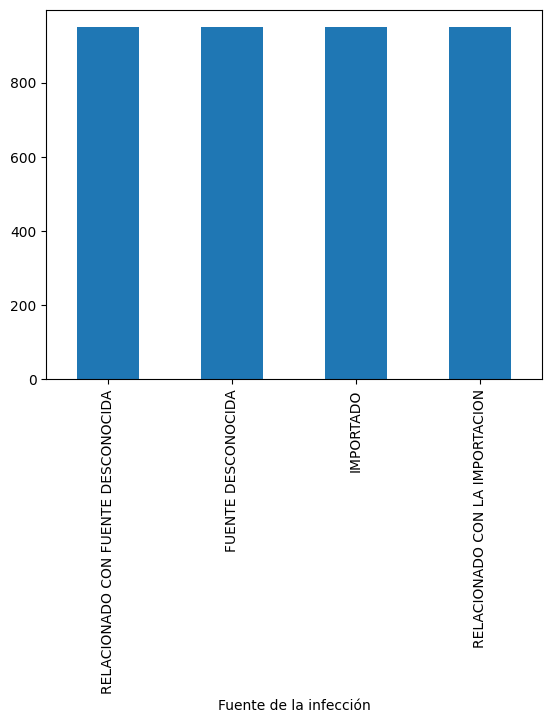

In [10]:
balanced_df['Fuente de la infección'].value_counts().plot(kind='bar')

# 4 - Modelo de clasificación con Redes Neuronales


In [11]:
#Se asigna las variables explicativas balanceadas a X y la predictora balanceada y
X = balanced_df.drop('Fuente de la infección', axis=1)
y = balanced_df['Fuente de la infección']

In [12]:
#División 70-30
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
y_train.value_counts()

Fuente de la infección
FUENTE DESCONOCIDA                    665
RELACIONADO CON FUENTE DESCONOCIDA    664
RELACIONADO CON LA IMPORTACION        664
IMPORTADO                             664
Name: count, dtype: int64

In [13]:
#Creacion del modelo
from sklearn.neural_network import MLPClassifier
model= MLPClassifier(solver='adam',learning_rate_init=0.01, alpha=1e-5, hidden_layer_sizes=(50), random_state=42, activation="logistic",
                    max_iter=500)
model.fit(X_train,y_train)

MLPClassifier(activation='logistic', alpha=1e-05, hidden_layer_sizes=50,
              learning_rate_init=0.01, max_iter=500, random_state=42)

In [14]:
#Creacion del modelo
from sklearn.neural_network import MLPClassifier
model= MLPClassifier(solver='adam',learning_rate_init=0.005, alpha=1e-5, hidden_layer_sizes=(45), random_state=42, activation="logistic",
                    max_iter=500)
model.fit(X_train,y_train)

/Users/samuelperezh/anaconda3/envs/upb/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(activation='logistic', alpha=1e-05, hidden_layer_sizes=45,
              learning_rate_init=0.005, max_iter=500, random_state=42)

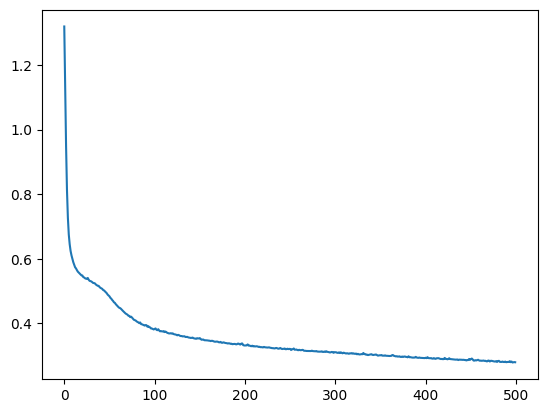

In [15]:
#Loss es la desviacion entre Y_train y el Y_pred
loss_values= model.loss_curve_
plt.plot(loss_values)

In [16]:
# Ejecutar este código para ver los thetas y los interceptos
# print(model.coefs_)
# print(model.intercepts_)

# 5 - Métricas del rendimiento del clasificador

In [17]:
y_test_pred = model.predict(X_test)

Al ser una red neuronal, esta se puede evaluar de diferentes maneras usando el parámetro average:
<br>
**Micro:** El uso de micro implica calcular las métricas globales agregando los recuentos totales de verdaderos positivos, falsos positivos y falsos negativos en todas las clases. Es útil cuando te interesa tener una visión general del rendimiento global del modelo en todo el conjunto de datos, sin importar el desequilibrio de clases. Se da el mismo peso a cada instancia y cada predicción.
<br>
**Weighted:** El uso de weighted implica calcular las métricas por clase y ponderarlas por el soporte de cada clase (número de instancias verdaderas de la clase). Es útil cuando deseas tener en cuenta el desequilibrio de clases al calcular las métricas. Las clases con mayor número de instancias tendrán un impacto mayor en el cálculo de las métricas. Se asigna un peso proporcional al tamaño de cada clase.

In [18]:
#Exactitud
accuracy = accuracy_score(y_test, y_test_pred)

#Precisión
precision_weighted = precision_score(y_test, y_test_pred, average='weighted')
precision_micro = precision_score(y_test, y_test_pred, average='micro')

#Sensibilidad (recall)
recall_weighted = recall_score(y_test, y_test_pred, average='weighted')
recall_micro = recall_score(y_test, y_test_pred, average='micro')

#F1 score
f1_weighted = f1_score(y_test, y_test_pred, average='weighted')
f1_micro = f1_score(y_test, y_test_pred, average='micro')

#Métricas
print("Exactitud:", accuracy)
print("Precisión:", precision_weighted, precision_micro)
print("Sensibilidad:", recall_weighted, recall_micro)
print("F1 Score:", f1_weighted, f1_micro)

Exactitud: 0.8700614574187884
Precisión: 0.8784322186684819 0.8700614574187884
Sensibilidad: 0.8700614574187884 0.8700614574187884
F1 Score: 0.871110116996447 0.8700614574187884


# 6 - Matriz de confusión

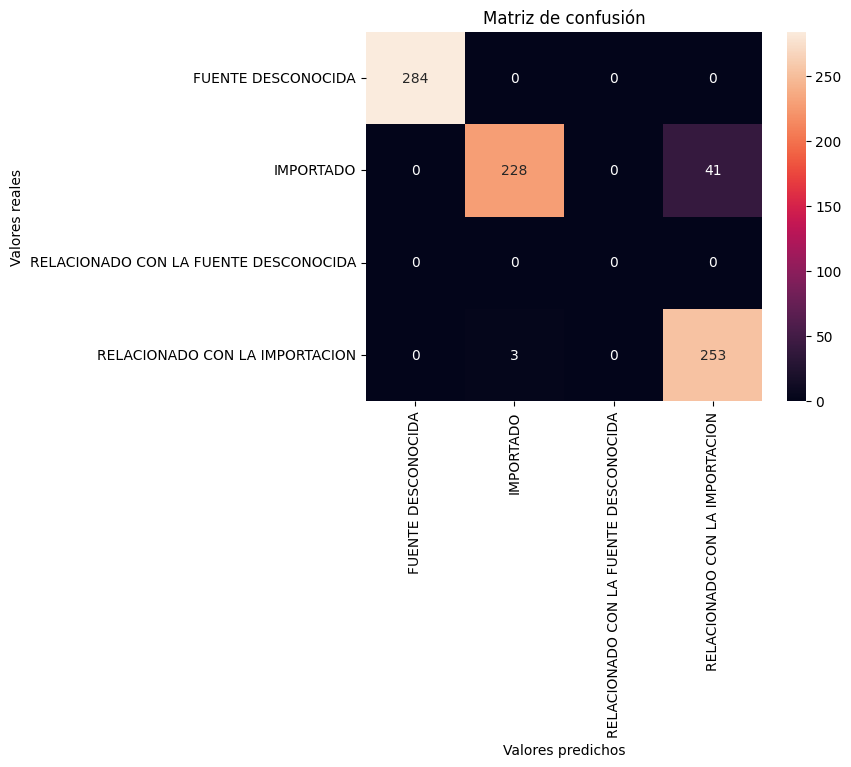

In [19]:
class_names=['FUENTE DESCONOCIDA', 'IMPORTADO', 'RELACIONADO CON LA FUENTE DESCONOCIDA', 'RELACIONADO CON LA IMPORTACION']
conf = confusion_matrix(y_test, y_test_pred, labels=class_names)

sns.heatmap(conf, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)

plt.title('Matriz de confusión')
plt.xlabel('Valores predichos')
plt.ylabel('Valores reales')

plt.show()

# 7 - Selección de la métrica más adecuada
En el contexto de predecir la fuente de infección del virus, la métrica más adecuada sería la **precisión**.

La precisión se enfoca en la proporción de casos positivos correctamente identificados en relación con el total de casos clasificados como positivos. En este caso, la precisión mediría la capacidad del modelo para predecir correctamente la fuente de infección, es decir, cuántos de los casos clasificados como FUENTE DESCONOCIDA, IMPORTADO, RELACIONADO CON LA FUENTE DESCONOCIDA y RELACIONADO CON LA IMPORTACION son realmente correctos.

La precisión es especialmente útil cuando se desea minimizar los falsos positivos, es decir, evitar clasificar incorrectamente casos negativos como positivos. En el contexto de predecir la fuente de infección, tener una alta precisión implica que las predicciones positivas son confiables y están respaldadas por datos sólidos, lo que es importante para tomar decisiones informadas sobre las acciones a seguir en respuesta a la infección.

# 8 - Grid Search

In [35]:
modelo = MLPClassifier()

# Parámetros para usar en el Grid Search
param_grid = {'solver':[ 'adam', 'sgd'], # Algoritmo
              'learning_rate_init' :[0.01,0.05,0.005], # Tasa de aprendizaje
              'hidden_layer_sizes': [(45),(60,20),(50,)], # Número de capas y cantidad de unidades por capa 
              'alpha':[1e-6,1e-5], # Coeficiente de regularización
              'activation':['logistic'],
              'random_state':[42],
              'max_iter':[5000]}

# Se crea el grid para iterar sobre los parámetros especificados
grid = GridSearchCV(modelo, param_grid, refit=True, verbose=0, scoring='precision_weighted', cv=10, n_jobs=-1)
grid.fit(X_train, y_train)

print(f'Los mejores parámetros son: {grid.best_params_}')

Los mejores parámetros son: {'activation': 'logistic', 'alpha': 1e-06, 'hidden_layer_sizes': (60, 20), 'learning_rate_init': 0.01, 'max_iter': 5000, 'random_state': 42, 'solver': 'adam'}


In [36]:
print(f'La precisión es de: {grid.best_score_}')

La precisión es de: 0.901335181190493


Como se puede ver, los mejores parámetros son: un coeficiente de regularización de 0,000001 con dos capas (60 y 20 neuronas respectivamente), una tasa de aprendizaje de 0,01 y el algoritmo de optimización adam.
<br>
Con este resultado obtuvimos una precisión del 90,1% lo que indica que es muy alta y la red neuronal está bien configurada.